# Analyse data ranges

In [1]:
import os
import time
import copy
import itertools

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import matplotlib.gridspec as gridspec
import scipy.stats as stats




from fault_management_uds.data.HDF5_functions import print_tree, load_dataframe_from_HDF5
from fault_management_uds.config import indicator_2_meta, bools_2_meta, error_indicators, natural_sensor_order
from fault_management_uds.data.load import import_external_metadata, import_metadata


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR, REFERENCE_DIR

# set random seed
seed = 42
np.random.seed(seed)

2024-11-14 10:50:15.971 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [2]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'
external_metadata = import_metadata(REFERENCE_DIR / 'external_metadata.csv')
metadata = import_metadata(REFERENCE_DIR / 'sensor_metadata.csv')

# Raw sensor path
raw_sensor_path = RAW_DATA_DIR / 'Bellinge' / 'sensor-data'

### Get sensor ranges


Types of ranges:
- Obvious limits: defined by the metadata
- Raw data: min, max, range, mean, std, 25th and 75th percentiles of the raw data
- Clean data: min, max, range, mean, std, 25th and 75th percentiles of the clean data

In [3]:
# # get operational limits based on metadata
# for sensor_name in natural_sensor_order:
#     sensor_ranges[sensor_name] = {}
#     sensor_ranges[sensor_name]['obvious_limits'] = {}
#     # get the metadata for the sensor
#     sensor_meta = metadata[metadata['IdMeasurement'] == sensor_name]
#     sensor_ranges[sensor_name]['obvious_limits']['min'] = sensor_meta['obvious_min'].values[0]
#     sensor_ranges[sensor_name]['obvious_limits']['max'] = sensor_meta['obvious_max'].values[0]
#     sensor_ranges[sensor_name]['obvious_limits']['range'] = sensor_ranges[sensor_name]['obvious_limits']['max'] - sensor_ranges[sensor_name]['obvious_limits']['min']

# round_to = 4
# # get the ranges for the raw and clean data
# for data_type in ['raw', 'clean']:
#     print(f"Data type: {data_type}")
#     for sensor_name in tqdm(natural_sensor_order, desc='Sensor', total=len(natural_sensor_order)):  
#         sensor_ranges[sensor_name][data_type] = {}
#         # load the data
#         data, _, _, _ = load_dataframe_from_HDF5(data_file_path, f"single_series/sewer_data/{sensor_name}/{data_type}")
#         # remove nan values
#         data = data.dropna(subset=['value'])
#         sensor_ranges[sensor_name][data_type]['min'] = data['value'].min()
#         sensor_ranges[sensor_name][data_type]['max'] = data['value'].max()
#         sensor_ranges[sensor_name][data_type]['range'] = sensor_ranges[sensor_name][data_type]['max'] - sensor_ranges[sensor_name][data_type]['min']
#         sensor_ranges[sensor_name][data_type]['mean'] = data['value'].mean().round(round_to)  
#         sensor_ranges[sensor_name][data_type]['std'] = round(data['value'].std(), round_to)
#         # quantiles for boxplot
#         sensor_ranges[sensor_name][data_type]['quantiles'] = {}
#         sensor_ranges[sensor_name][data_type]['quantiles']['25'] = data['value'].quantile(0.25).round(round_to)
#         sensor_ranges[sensor_name][data_type]['quantiles']['50'] = data['value'].quantile(0.50).round(round_to)
#         sensor_ranges[sensor_name][data_type]['quantiles']['75'] = data['value'].quantile(0.75).round(round_to)
        
#     #     break
#     # break

# # save the sensor ranges
# with open(REFERENCE_DIR / 'sensor_ranges.json', 'w') as f:
#     json.dump(sensor_ranges, f, default=str, indent=4)


# del data

In [4]:
# load the sensor ranges
with open(REFERENCE_DIR / 'sensor_ranges.json', 'r') as f:
    sensor_ranges = json.load(f)

## Visualize sensor ranges

In [5]:
figure_save_folder = FIGURES_DIR / 'dataset'
if not os.path.exists(figure_save_folder):
    os.makedirs(figure_save_folder)

In [6]:
range_save_folder = figure_save_folder / 'ranges'
range_save_folder.mkdir(parents=True, exist_ok=True)

In [7]:
sensor_types = metadata['Type'].unique()
for sensor_type in sensor_types:
    num_sensors = metadata[metadata['Type'] == sensor_type].shape[0]
    print(f"Sensor type: {sensor_type}, Number of sensors: {num_sensors}")


Sensor type: Level, Number of sensors: 13
Sensor type: Position, Number of sensors: 1
Sensor type: Discharge, Number of sensors: 1
Sensor type: Power, Number of sensors: 4


1. Visualize min max plots
2. Visualize normal distribution plots

In [8]:
sensor_ranges['G80F11B_Level1'].keys()

dict_keys(['obvious_limits', 'raw', 'clean'])

#### Min Max Plots

Sensor type: Level


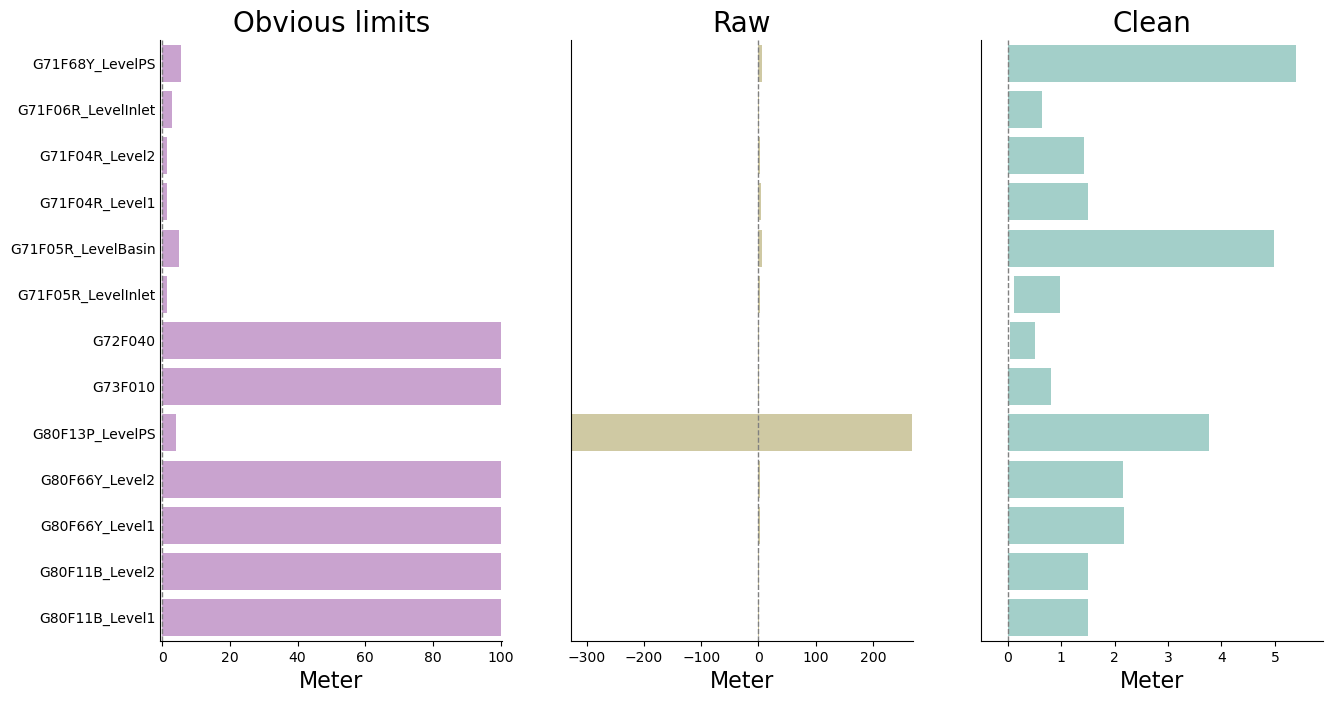

Sensor type: Position


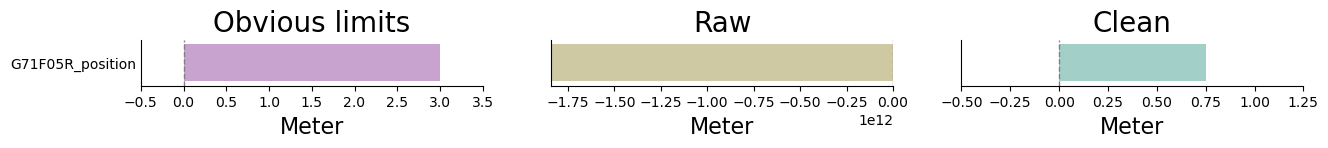

Sensor type: Discharge


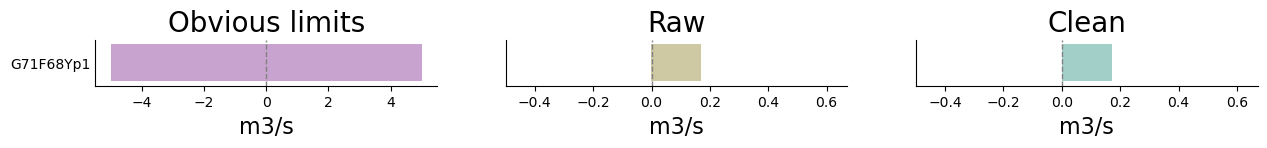

Sensor type: Power


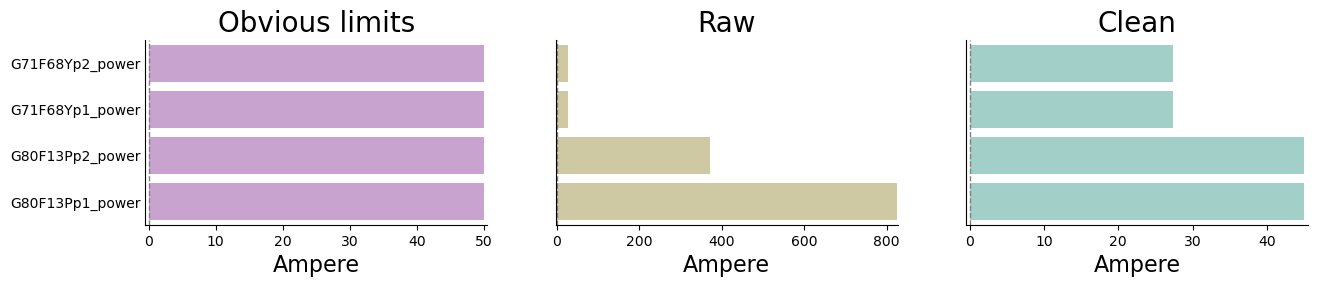

In [10]:
for sensor_type in sensor_types:
    print(f"Sensor type: {sensor_type}")
    # get relevant sensors
    sensor_meta = metadata[metadata['Type'] == sensor_type]
    sensors = sensor_meta['IdMeasurement'].tolist()
    relevant_sensors = [sensor for sensor in natural_sensor_order if sensor in sensors]
    # assert the UnitAlias 
    unit_alias = sensor_meta['UnitAlias'].unique()
    assert len(unit_alias) == 1, f"UnitAlias should be the same for all sensors in a sensor type, but got {unit_alias}"

    # create 3 side by side plots for each sensor
    height = len(relevant_sensors) * 0.6
    fig, axs = plt.subplots(1, 3, figsize=(15, height))
    colors = ['#BC8CC4', '#C4BC8C', '#8CC4BC']
    for i, (ax, range_type) in enumerate(zip(axs, ['obvious_limits', 'raw', 'clean'])):
        max_of_max = -np.inf
        min_of_min = np.inf
        for sensor_name in relevant_sensors:
            _min, _max, _range = sensor_ranges[sensor_name][range_type]['min'], sensor_ranges[sensor_name][range_type]['max'], sensor_ranges[sensor_name][range_type]['range']
            max_of_max = max(max_of_max, _max)
            min_of_min = min(min_of_min, _min)
            # visualize horizontaal bar
            ax.barh(sensor_name, _range, left=_min, color=colors[i], alpha=0.8)
    
        # Add a vertical line at 0
        ax.axvline(0, color='grey', lw=1, ls='--')
        # Set title
        ax.set_title(f"{range_type.replace('_', ' ').capitalize()}", fontsize=20)
        # adjust x limits
        ax.set_xlim(min_of_min-0.5, max_of_max+0.5)
        # Set y-limits to fit all bars
        ax.set_ylim(-0.5, len(relevant_sensors) - 0.5)
        # Set the x-axis label, 1 for all subplots
        ax.set_xlabel(f"{unit_alias[0]}", fontsize=16)
        # Make y ticks larger
        ax.tick_params(axis='y', length=0)
        # Only add labels to the first subplot (on the left)
        if i != 0:
            ax.set_yticklabels([])  # Hide y-tick labels for other subplots

        # remove left, right and top spines
        ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)#; ax.spines['left'].set_visible(False)
    #plt.tight_layout()  
    plt.show()
    #break




- Bad obvious max for iFix and Danova
- LevelPS reaches some insane values
- Clean only seems reasonable

Sensor type: Level


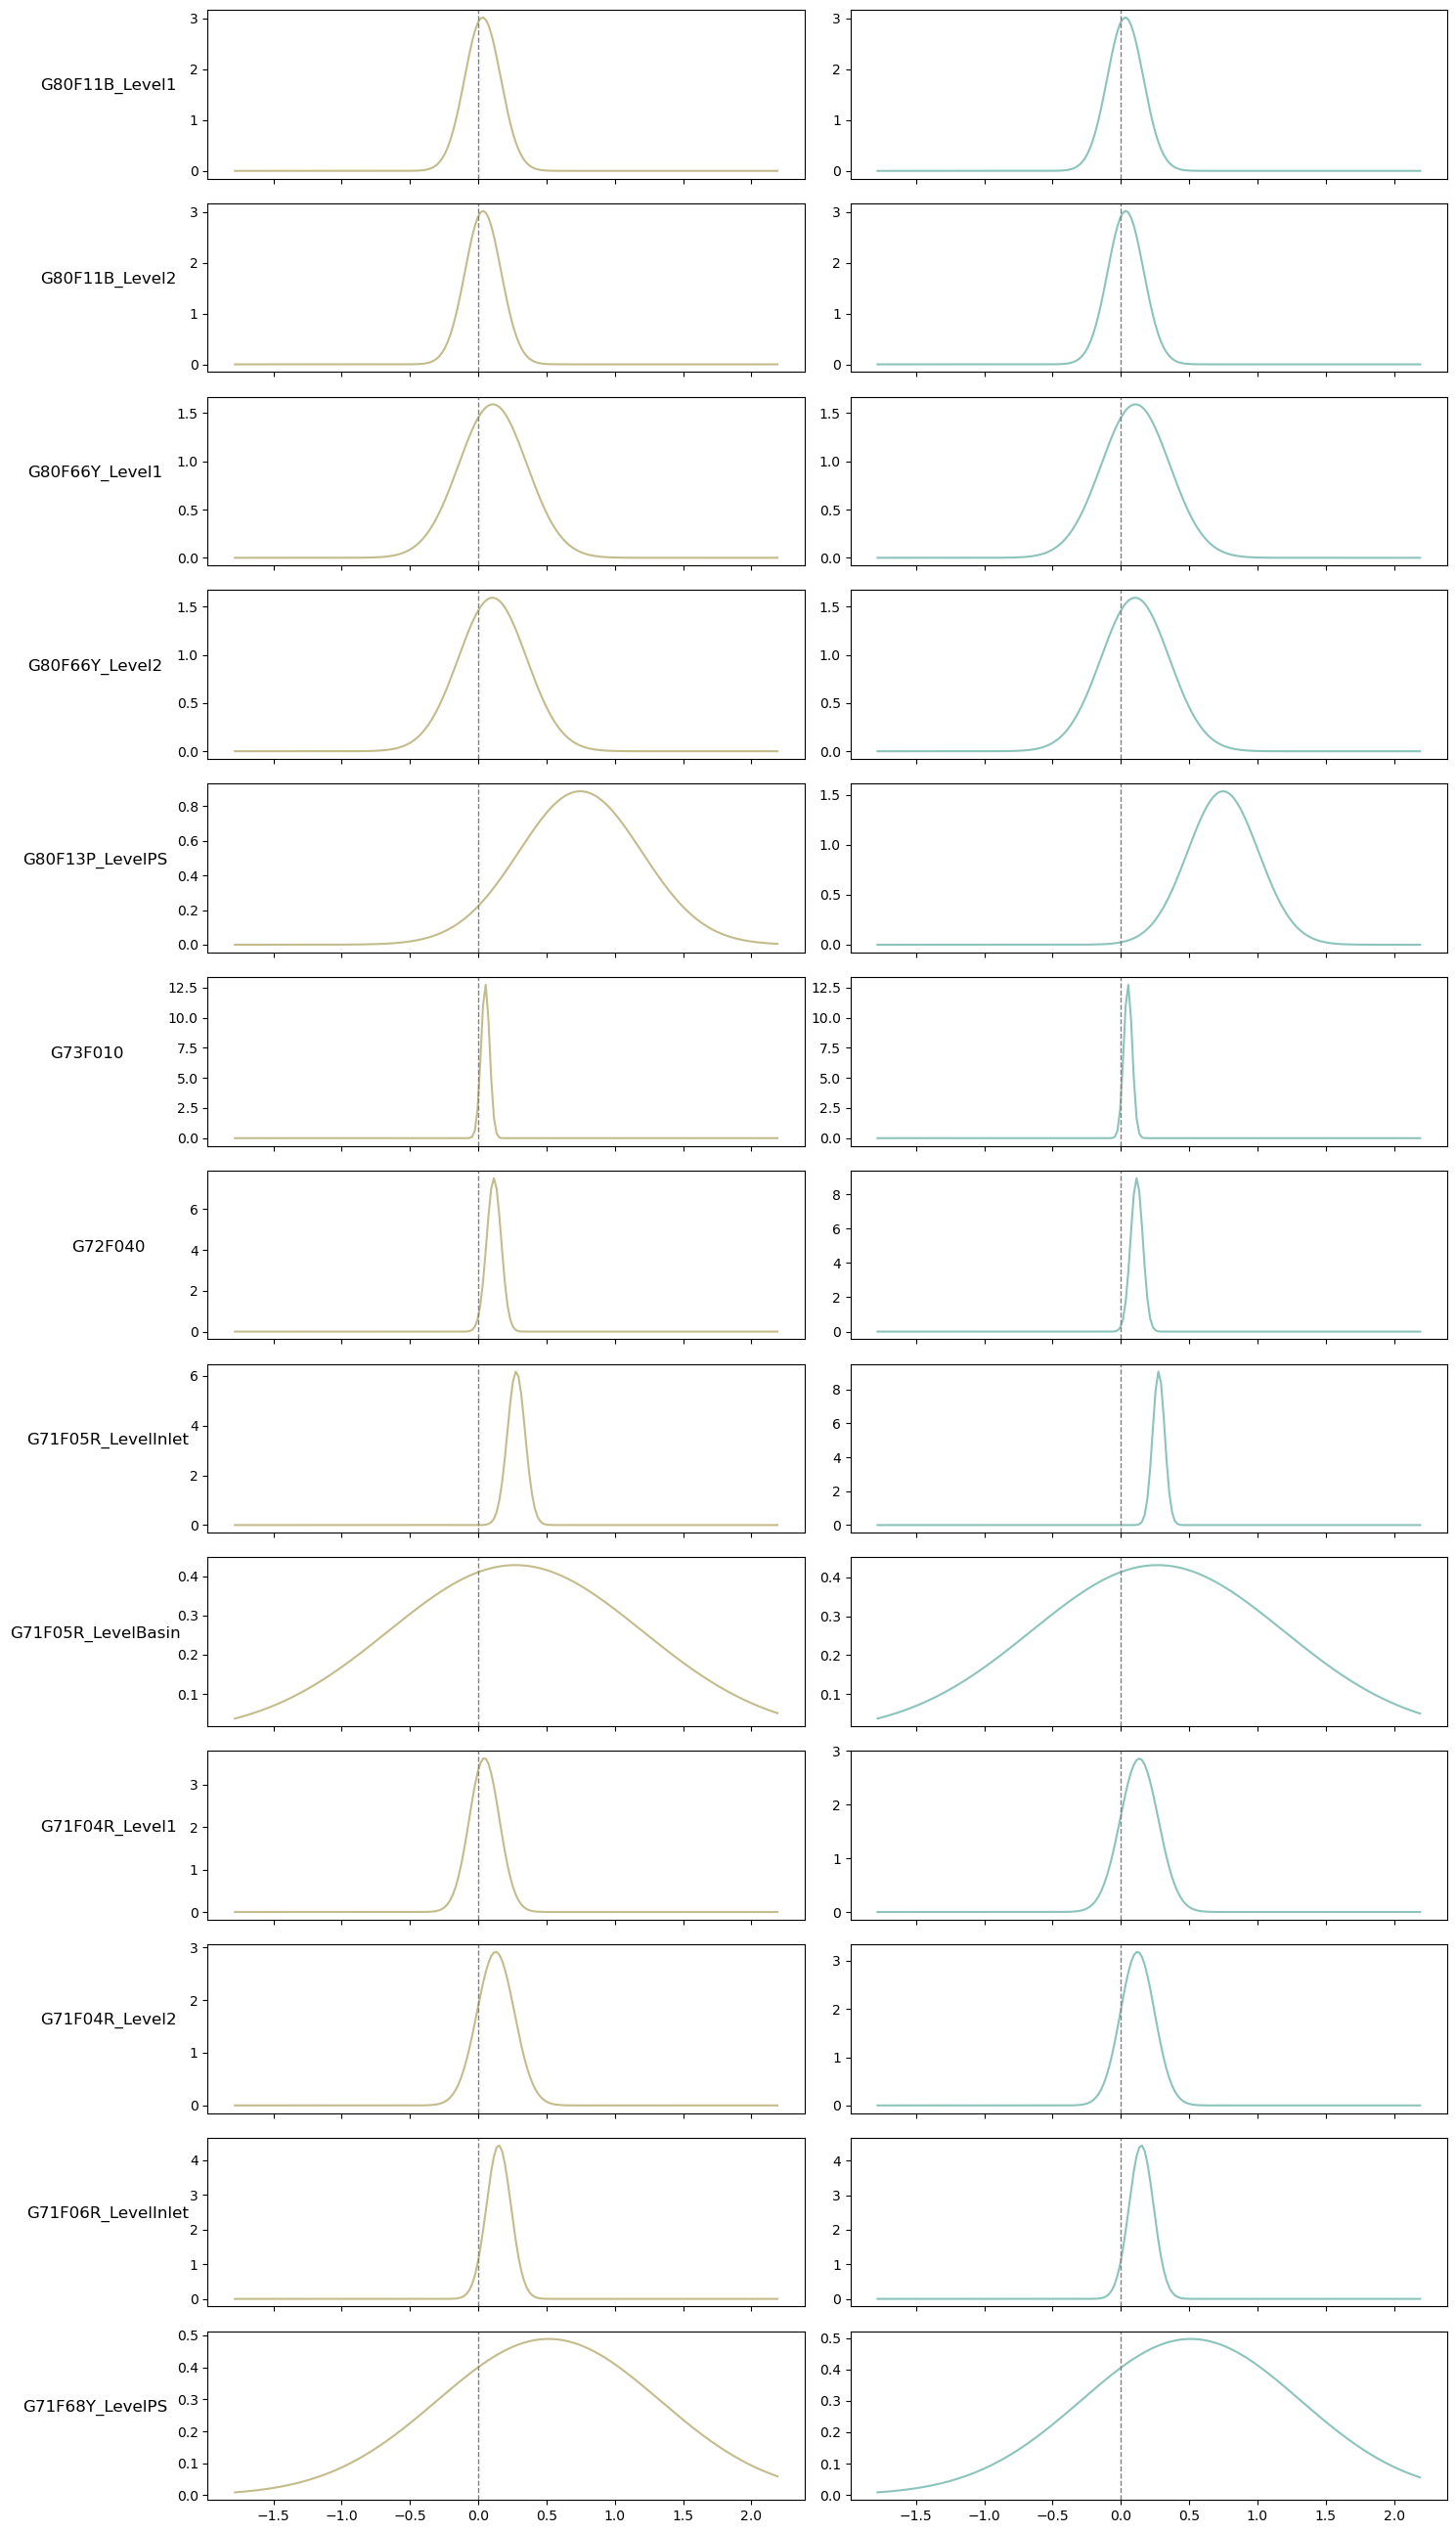

Sensor type: Position


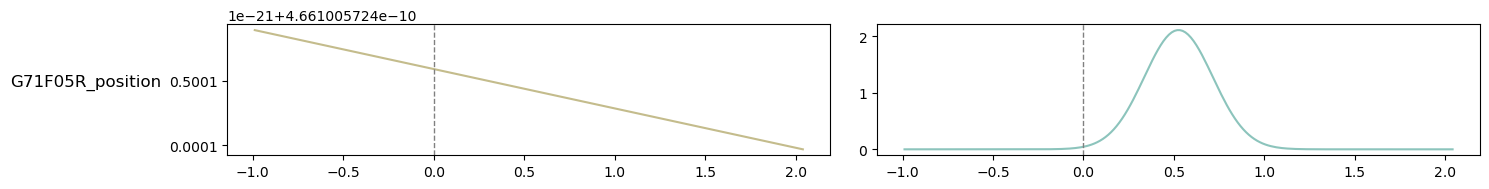

Sensor type: Discharge


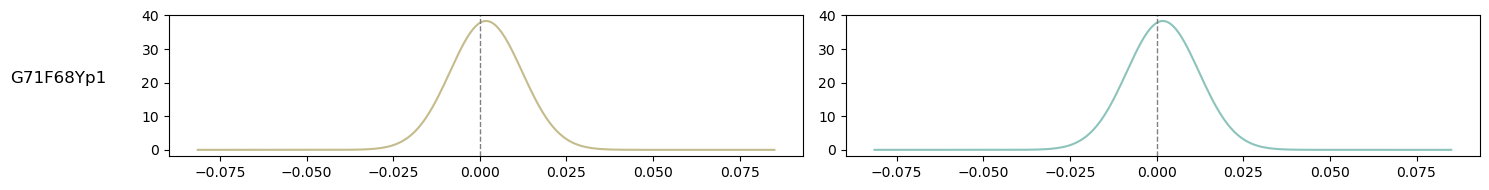

Sensor type: Power


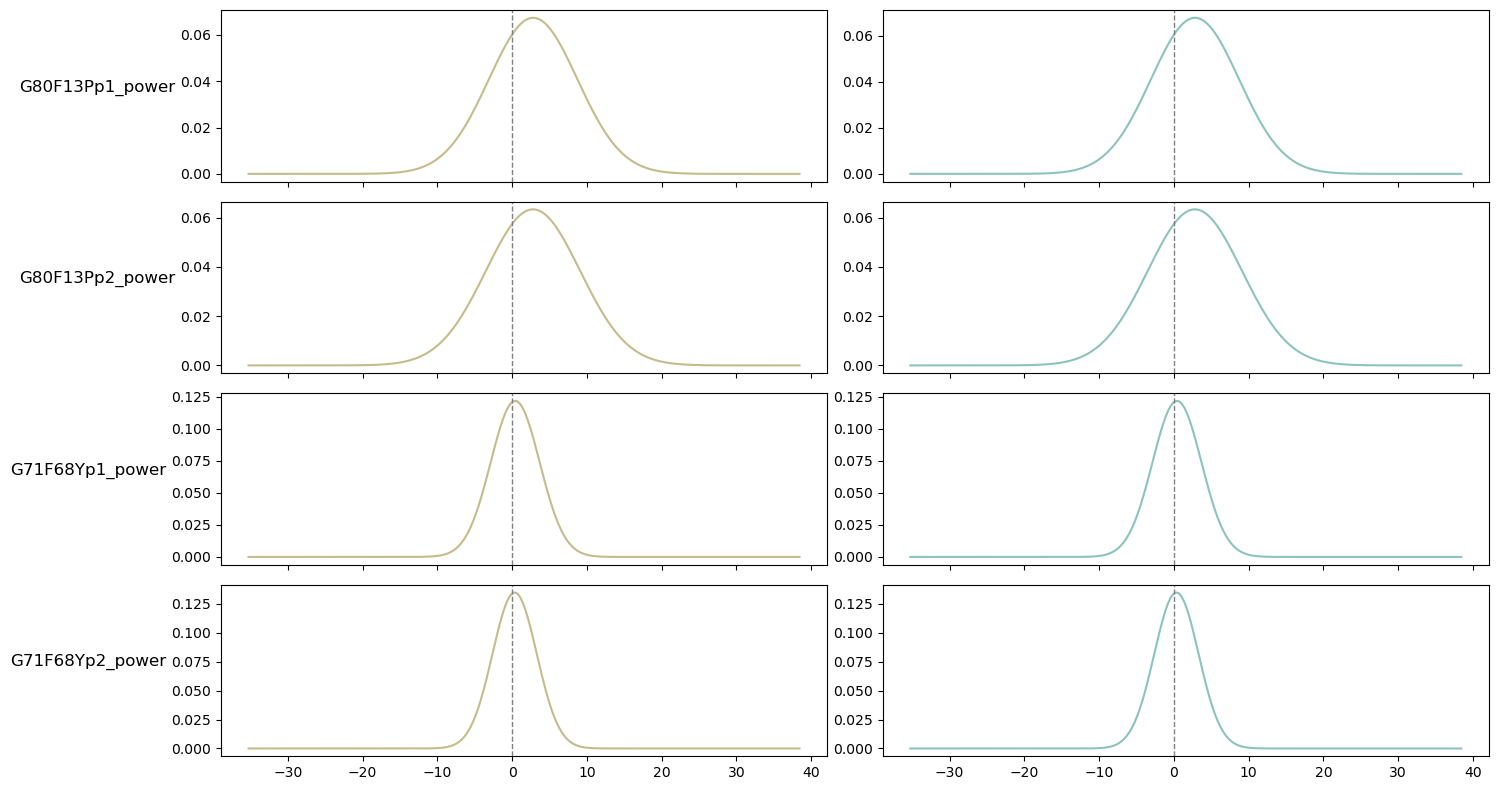

In [11]:
for sensor_type in sensor_types:
    print(f"Sensor type: {sensor_type}")
    # get relevant sensors
    sensor_meta = metadata[metadata['Type'] == sensor_type]
    sensors = sensor_meta['IdMeasurement'].tolist()
    relevant_sensors = [sensor for sensor in natural_sensor_order if sensor in sensors]
    # assert the UnitAlias 
    unit_alias = sensor_meta['UnitAlias'].unique()
    assert len(unit_alias) == 1, f"UnitAlias should be the same for all sensors in a sensor type, but got {unit_alias}"

    # create subplots for each sensor
    rows = len(relevant_sensors)
    cols = 2
    fig, axs = plt.subplots(rows, cols, figsize=(15, rows * 2), sharex='col')
    axs = axs.ravel()  # flatten the axes

    colors = ['#C4BC8C', '#8CC4BC']

    means = [sensor_ranges[sensor_name]['clean']['mean'] for sensor_name in relevant_sensors]
    avg_mean = np.mean(means)
    stds = [sensor_ranges[sensor_name]['clean']['std'] for sensor_name in relevant_sensors]
    avg_std = np.mean(stds)
    for i, sensor_name in enumerate(relevant_sensors):
        for j, range_type in enumerate(['raw', 'clean']):
            ax = axs[i * cols + j]
            # Get mean and standard deviation
            mean = sensor_ranges[sensor_name][range_type]['mean']
            std = sensor_ranges[sensor_name][range_type]['std']

            # Create x-axis values for the normal distribution
            stds = 8
            x = np.linspace(avg_mean - stds*avg_std, avg_mean + stds*avg_std, 200)
            # Calculate probability density for the normal distribution
            y = stats.norm.pdf(x, mean, std)
            # Plot the normal distribution
            ax.plot(x, y, label=sensor_name, color=colors[j])
            # add a vertical line at 0
            ax.axvline(0, color='grey', lw=1, ls='--')

            #ax.legend(title='Sensors', loc='upper left')
            #ax.set_title(f"{sensor_name} - {range_type.replace('_', ' ').capitalize()}", fontsize=12)
            # sat y axis label

            if j == 0:
                ax.set_ylabel(f"{sensor_name}", fontsize=12, rotation=0, labelpad=60)


    plt.tight_layout()
    plt.show()


Barplots of the standard deviation of the sensors

In [9]:
sensor_types

array(['Level', 'Position', 'Discharge', 'Power'], dtype=object)

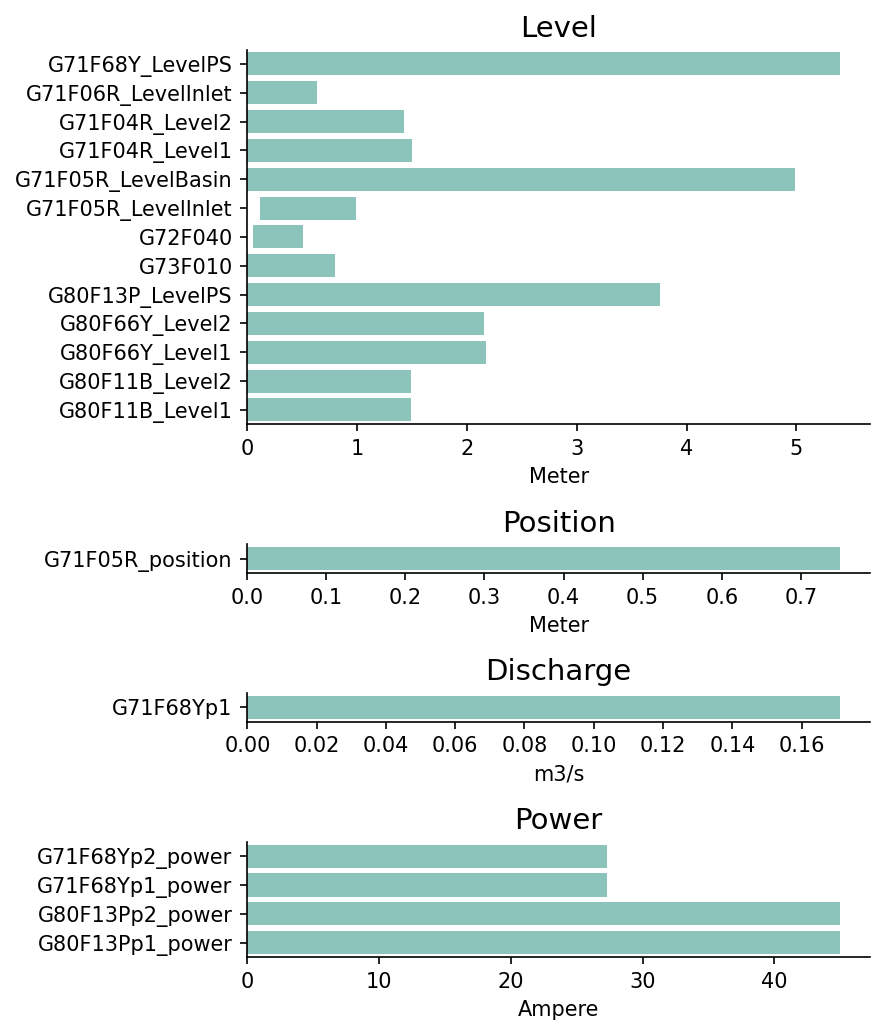

In [10]:
range_type = 'clean'
color = '#8CC4BC'

# selectively set subplot heights
n_sensor_types = len(sensor_types)
height_ratios = [len(metadata[metadata['Type'] == sensor_type]) for sensor_type in sensor_types]
fig, axs = plt.subplots(n_sensor_types, 1, figsize=(6, 7), gridspec_kw={'height_ratios': height_ratios}, dpi=150)


#plt.subplots_adjust(hspace=10.4)  # Adjust hspace value as needed

for i, sensor_type in enumerate(sensor_types):
    ax = axs[i]
    # get relevant sensors
    sensor_meta = metadata[metadata['Type'] == sensor_type]
    sensors = sensor_meta['IdMeasurement'].tolist()
    relevant_sensors = [sensor for sensor in natural_sensor_order if sensor in sensors]
    # assert the UnitAlias 
    unit_alias = sensor_meta['UnitAlias'].unique()
    assert len(unit_alias) == 1, f"UnitAlias should be the same for all sensors in a sensor type, but got {unit_alias}"

    # get the max and min of the ranges
    max_of_max = -np.inf
    min_of_min = np.inf
    for sensor_name in relevant_sensors:
        _min, _max, _range = sensor_ranges[sensor_name][range_type]['min'], sensor_ranges[sensor_name][range_type]['max'], sensor_ranges[sensor_name][range_type]['range']
        max_of_max = max(max_of_max, _max)
        min_of_min = min(min_of_min, _min)
        # visualize horizontaal bar
        ax.barh(sensor_name, _range, left=_min, color=color)

    # Add a vertical line at 0
    #ax.axvline(0, color='grey', lw=1, ls='--')
    # Set title
    ax.set_title(f"{sensor_type.replace('_', ' ').capitalize()}", fontsize=14)
    # adjust x limits
    #ax.set_xlim(min_of_min-0.5, max_of_max+0.5)
    # Set y-limits to fit all bars
    ax.set_ylim(-0.5, len(relevant_sensors) - 0.5)
    # Set the x-axis label, 1 for all subplots
    ax.set_xlabel(f"{unit_alias[0]}")#, fontsize=12)

    # remove left, right and top spines
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)
plt.tight_layout()  
# save the figure
plt.savefig(range_save_folder / f"{range_type}_ranges.png")
plt.show()

In [11]:
sensor_ranges[sensor_name][range_type]

{'min': 0.0,
 'max': 27.3,
 'range': 27.3,
 'mean': 0.3346,
 'std': 2.9602,
 'quantiles': {'25': 0.0, '50': 0.0, '75': 0.0}}

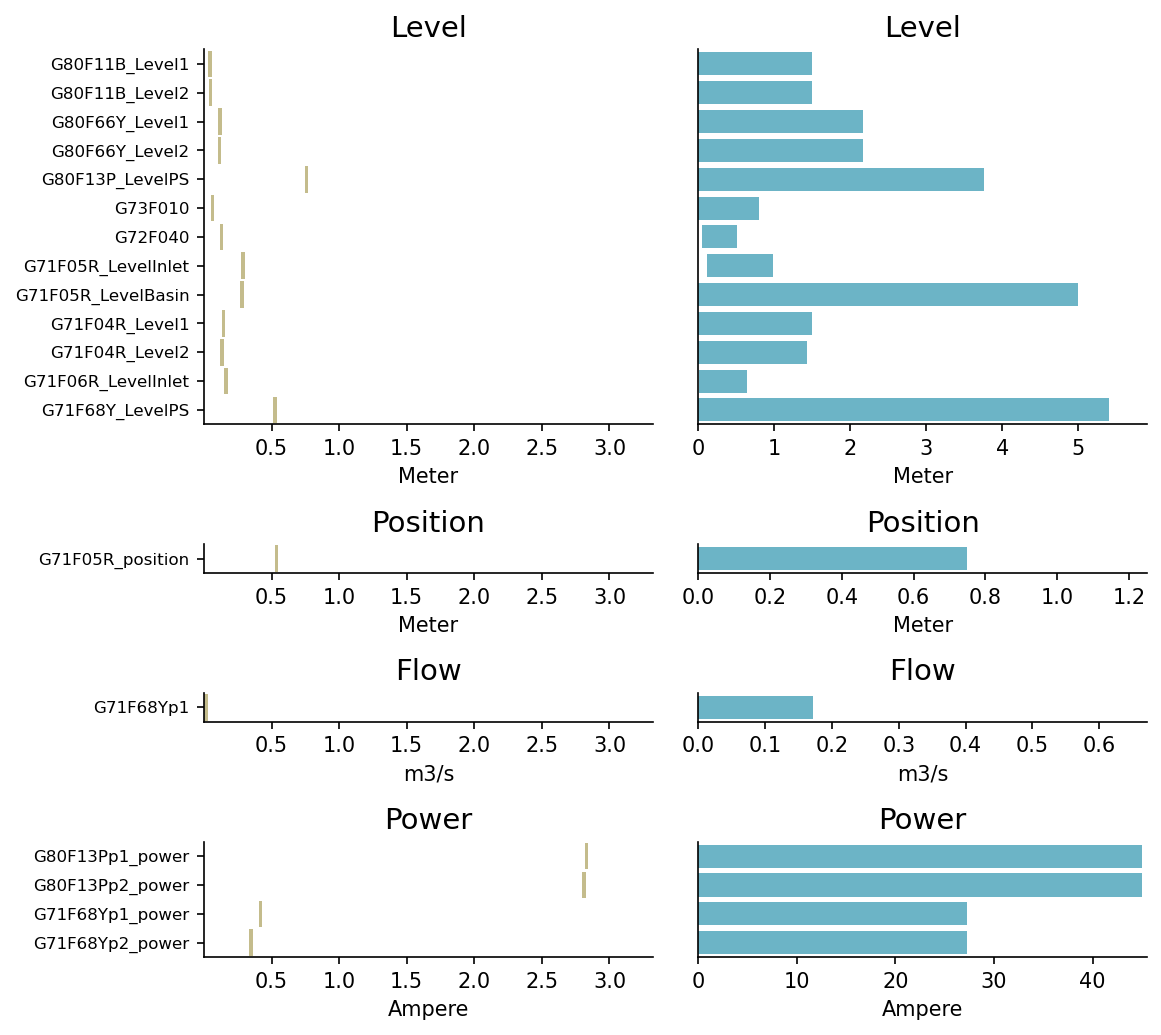

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming sensor_ranges, sensor_types, metadata, and natural_sensor_order are defined

range_type = 'clean'

color_avg = '#C4BC8C'
color_range = '#47A1B8'

# Calculate subplot heights
n_sensor_types = len(sensor_types)
height_ratios = [len(metadata[metadata['Type'] == sensor_type]) for sensor_type in sensor_types]

# Create a figure with an additional column for averages
fig, axs = plt.subplots(n_sensor_types, 2, figsize=(8, 7), gridspec_kw={'height_ratios': height_ratios}, dpi=150)


max_of_avg = -np.inf
min_of_avg = np.inf

for sensor_name in natural_sensor_order:
    avg = sensor_ranges[sensor_name][range_type]['mean']
    max_of_avg = max(max_of_avg, avg)
    min_of_avg = min(min_of_avg, avg)

bar_width = 0.025
gap = 0.04

for i, sensor_type in enumerate(sensor_types):
    ax_avg, ax_range = axs[i]  # Unpack the axes for average and main plot

    # Get relevant sensors
    sensor_meta = metadata[metadata['Type'] == sensor_type]
    sensors = sensor_meta['IdMeasurement'].tolist()
    relevant_sensors = [sensor for sensor in natural_sensor_order if sensor in sensors]

    # Assert the UnitAlias
    unit_alias = sensor_meta['UnitAlias'].unique()
    assert len(unit_alias) == 1, f"UnitAlias should be the same for all sensors in a sensor type, but got {unit_alias}"

    # Calculate max, min, and average
    max_of_max = -np.inf
    min_of_min = np.inf

    for j, sensor_name in enumerate(relevant_sensors):
        _min, _max, _range = sensor_ranges[sensor_name][range_type]['min'], sensor_ranges[sensor_name][range_type]['max'], sensor_ranges[sensor_name][range_type]['range']
        avg = sensor_ranges[sensor_name][range_type]['mean']
        max_of_max = max(max_of_max, _max)
        min_of_min = min(min_of_min, _min)

        # Visualize vertical line for average
        start_position = j - 0.5 + gap
        ax_avg.broken_barh([(avg, bar_width)], (start_position, 1 - 2 * gap), facecolors=color_avg)


        # Visualize horizontal bar for eange
        ax_range.barh(sensor_name, _range, left=_min, color=color_range, alpha=0.8)
    
    # Remove x and y ticks from the average plot
    if sensor_type == "Discharge":
        sensor_type = 'Flow'
    ax_avg.set_title(f"{sensor_type.replace('_', ' ').capitalize()}", fontsize=14)
    ax_avg.set_xlim(min_of_avg, max_of_avg + 0.5)
    ax_avg.set_ylim(-0.5, len(relevant_sensors) - 0.5)
    ax_avg.set_xlabel(f"{unit_alias[0]}")
    # set x-ticks for each sensor name
    ax_avg.set_yticks(np.arange(len(relevant_sensors)))
    ax_avg.set_yticklabels(relevant_sensors, fontsize=8)
    ax_avg.invert_yaxis()


    # Set title
    ax_range.set_title(f"{sensor_type.replace('_', ' ').capitalize()}", fontsize=14)
    ax_range.set_yticks([])
    # Adjust x limits
    ax_range.set_xlim(min_of_min, max_of_max + 0.5)
    # Set y-limits to fit all bars
    ax_range.set_ylim(-0.5, len(relevant_sensors) - 0.5)
    # Set the x-axis label, 1 for all subplots
    ax_range.set_xlabel(f"{unit_alias[0]}")
    ax_range.invert_yaxis()

    # Remove left, right, and top spines
    ax_range.spines['right'].set_visible(False)
    ax_range.spines['top'].set_visible(False)
    ax_avg.spines['right'].set_visible(False)
    ax_avg.spines['top'].set_visible(False)

plt.tight_layout()
# Save the figure
plt.savefig(range_save_folder / f"{range_type}_avg_and_range.png")
plt.show()
plt.close()

Standard deviation of the sensors

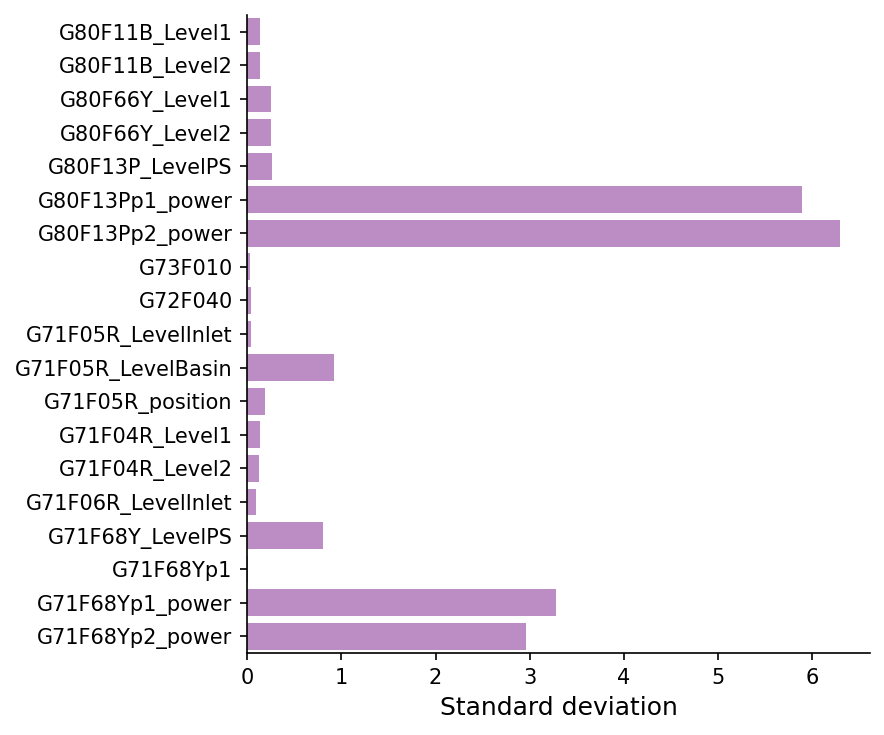

In [16]:
# create 3 side by side plots for each sensor
fig, ax = plt.subplots(figsize=(6, 5), dpi=150)
colors = ['#BC8CC4', '#C4BC8C', '#8CC4BC']

color = '#BC8CC4'
range_type = 'clean'
for sensor_name in natural_sensor_order:
    std = sensor_ranges[sensor_name][range_type]['std']
    # visualize horizontaal bar
    ax.barh(sensor_name, std, color=color)
# Set y-limits to fit all bars
ax.set_ylim(-0.5, len(natural_sensor_order) - 0.5)
# invert y axis
ax.invert_yaxis()
# Make y ticks larger
ax.tick_params(axis='y')
ax.set_xlabel(f"Standard deviation", fontsize=12)
# remove spines
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False)#; ax.spines['bottom'].set_visible(False); ax.spines['left'].set_visible(False)
plt.tight_layout()  
# save the figure
plt.savefig(range_save_folder / 'sensor_std.png')
plt.show()
